<a href="https://colab.research.google.com/github/virdakristy/TugasMachineLearning/blob/main/diabetes_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
warnings.filterwarnings("ignore")
%matplotlib inline

# Import Data

In [6]:
dataset = pd.read_csv("drive/MyDrive/Virda_TM9/dataset/diabetes.csv")

In [7]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [9]:
dataset.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

# Data Preparation

## Cek Missing Value

In [256]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Cek Tipe Data

In [257]:
dataset.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure               float64
SkinThickness                 int64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

## Cek Data Outlier

### Nilai Outlier dengan Boxplot

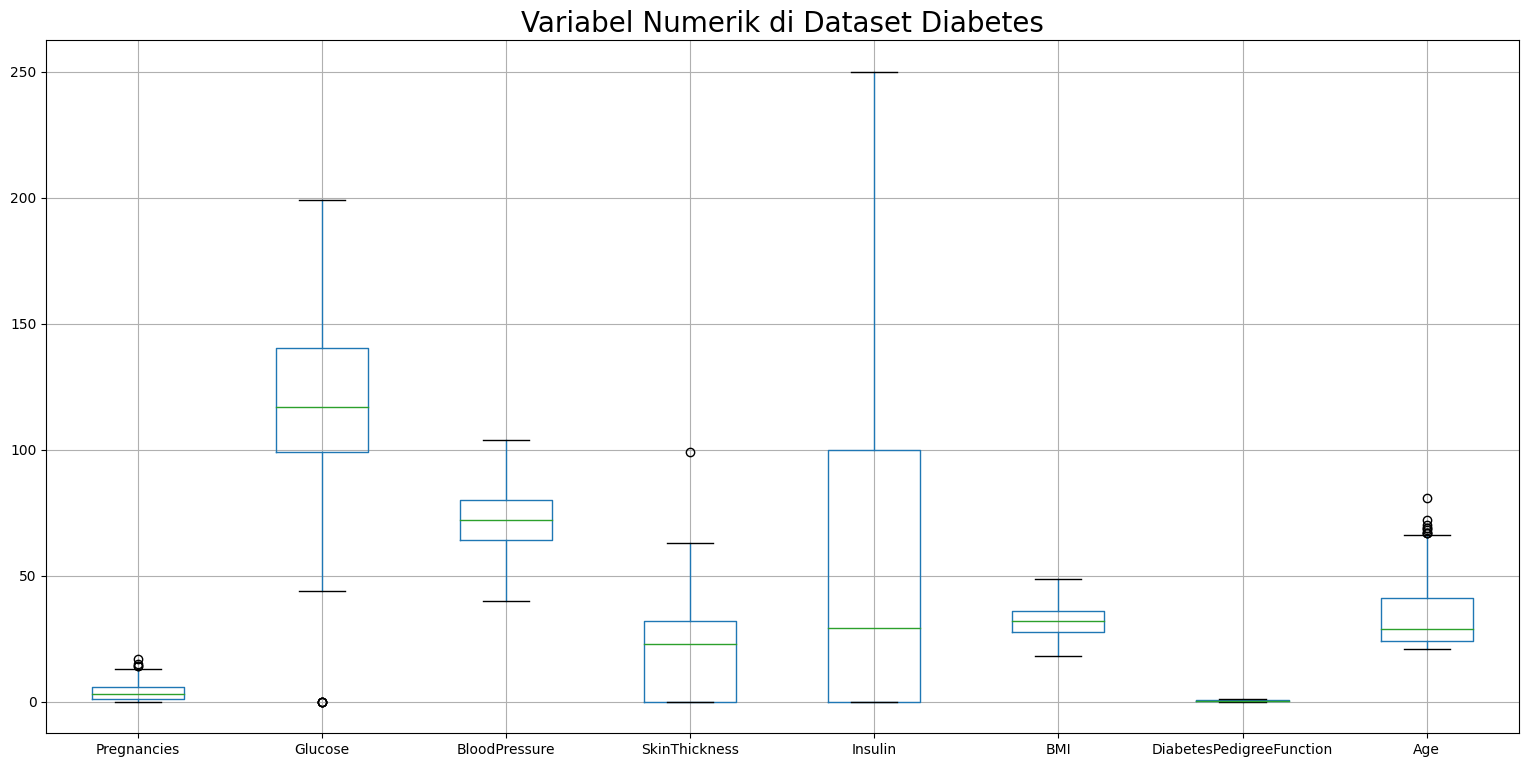

In [261]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
plt.figure(figsize=(19,9))
dataset[cols].boxplot()
plt.title("Variabel Numerik di Dataset Diabetes", fontsize=20)
plt.show()

### Nilai Outlier dengan Z-Score

Sumber : https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/

In [262]:
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers
data_outlier = {}
for col in cols:
  data_outlier[col] = detect_outliers_zscore(dataset[col])
  print("Outliers from Z-scores method (", col, ")", len(data_outlier[col]), "outlier :", data_outlier[col])



Outliers from Z-scores method ( Pregnancies ) 4 outlier : [15, 17, 14, 14]
Outliers from Z-scores method ( Glucose ) 5 outlier : [0, 0, 0, 0, 0]
Outliers from Z-scores method ( BloodPressure ) 0 outlier : []
Outliers from Z-scores method ( SkinThickness ) 1 outlier : [99]
Outliers from Z-scores method ( Insulin ) 0 outlier : []
Outliers from Z-scores method ( BMI ) 0 outlier : []
Outliers from Z-scores method ( DiabetesPedigreeFunction ) 0 outlier : []
Outliers from Z-scores method ( Age ) 5 outlier : [69, 72, 81, 70, 69]


### Nilai Outlier dengan IQR

In [263]:

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data:
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers
data_outlier = {}
for col in cols:
  data_outlier[col] = detect_outliers_iqr(dataset[col])
  print("Outliers from Z-scores method (", col, ")", len(data_outlier[col]), "outlier :", data_outlier[col])

Outliers from Z-scores method ( Pregnancies ) 4 outlier : [14, 14, 15, 17]
Outliers from Z-scores method ( Glucose ) 5 outlier : [0, 0, 0, 0, 0]
Outliers from Z-scores method ( BloodPressure ) 0 outlier : []
Outliers from Z-scores method ( SkinThickness ) 1 outlier : [99]
Outliers from Z-scores method ( Insulin ) 0 outlier : []
Outliers from Z-scores method ( BMI ) 0 outlier : []
Outliers from Z-scores method ( DiabetesPedigreeFunction ) 0 outlier : []
Outliers from Z-scores method ( Age ) 9 outlier : [67, 67, 67, 68, 69, 69, 70, 72, 81]


## Handling Data Outlier

### Handling Data Outlier BloodPressure

In [264]:
mean_blood = np.mean(dataset['BloodPressure'])
mean_blood

71.93861216968959

In [265]:
for i in data_outlier['BloodPressure']:
  dataset['BloodPressure'] = np.where(dataset['BloodPressure']==i, mean_blood, dataset['BloodPressure'])

detect_outliers_iqr(dataset['BloodPressure'])

[]

### Handling Data Outlier Insulin

In [242]:
median_insulin = np.median(dataset['Insulin'])
median_insulin

29.09375

In [243]:
for i in data_outlier['Insulin']:
  dataset['Insulin'] = np.where(dataset['Insulin']==i, median_insulin, dataset['Insulin'])

detect_outliers_iqr(dataset['Insulin'])

[]

### Handling Data Outlier Diabetes Pedigree Function

In [244]:
median_DPF = np.median(dataset['DiabetesPedigreeFunction'])
median_DPF

0.37109375

In [245]:
for i in data_outlier['DiabetesPedigreeFunction']:
  dataset['DiabetesPedigreeFunction'] = np.where(dataset['DiabetesPedigreeFunction']==i, median_DPF, dataset['DiabetesPedigreeFunction'])

detect_outliers_iqr(dataset['DiabetesPedigreeFunction'])

[]

### Handling Data Outlier BMI

In [246]:
mean_BMI = np.mean(dataset['BMI'])
mean_BMI

32.107793565981815

In [247]:
for i in data_outlier['BMI']:
  dataset['BMI'] = np.where(dataset['BMI']==i, mean_BMI, dataset['BMI'])

detect_outliers_iqr(dataset['BMI'])

[]

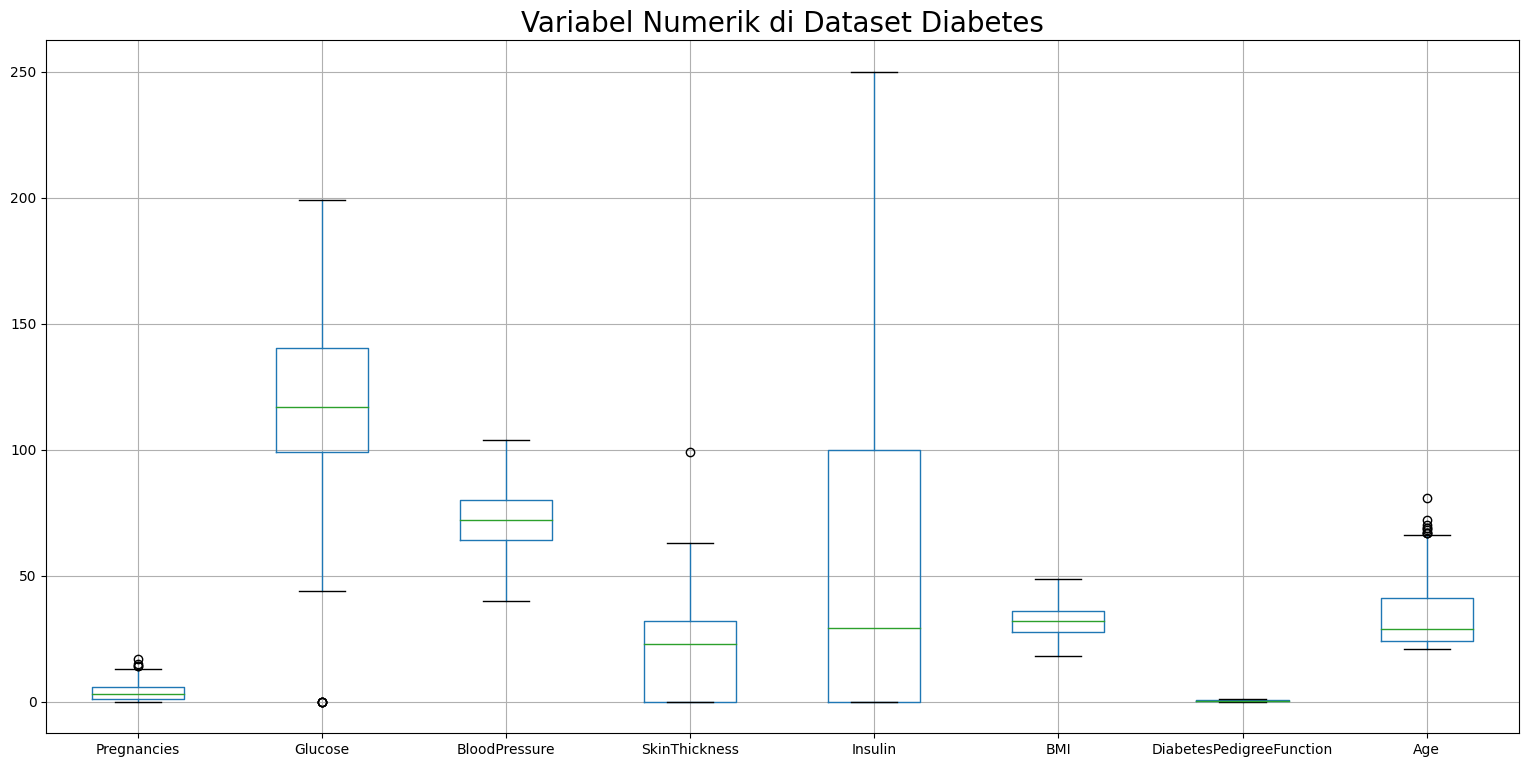

In [248]:
plt.figure(figsize=(19,9))
dataset[cols].boxplot()
plt.title("Variabel Numerik di Dataset Diabetes", fontsize=20)
plt.show()

## Inisiasi Variabel Fitur dan Label

In [249]:
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome']

## Oversampling Data

In [250]:
!pip install imbalanced-learn

In [251]:
from imblearn.over_sampling import SMOTE

In [252]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [253]:
X, y = SMOTE().fit_resample(X, y)
print(sorted(Counter(y).items()))

[(0, 500), (1, 500)]


## Scalling Data


In [254]:
scaler =  MinMaxScaler()
# transform data
X = scaler.fit_transform(X)
print(X)

[[0.35294118 0.74371859 0.5        ... 0.50326797 0.59479957 0.48333333]
 [0.05882353 0.42713568 0.40625    ... 0.2745098  0.29577465 0.16666667]
 [0.47058824 0.91959799 0.375      ... 0.16666667 0.64355363 0.18333333]
 ...
 [0.23529412 0.42713568 0.51353467 ... 0.40975373 0.34578519 0.16666667]
 [0.41176471 0.6080402  0.61041106 ... 0.32038526 0.25458694 0.06666667]
 [0.11764706 0.44221106 0.55616943 ... 0.50586866 0.5335421  0.1       ]]


# Train Model



# Data Split


In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Training Model


## K-Nearest Neighbours

In [266]:
model = KNeighborsClassifier(n_neighbors=39, leaf_size=30)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=39)

### Model Validation

#### Basic Validation

In [267]:
def model_validation_metrics(confusion_matrix):
  tn, fp, fn, tp = confusion_matrix.ravel()
  return (tp+tn)/(tp+tn+fp+fn),tp/(tp+fp),tp/(tp+fn)

def roc_curve_func(y_true,y_score):
  # Compute fpr, tpr, thresholds and roc auc
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = roc_auc_score(y_true, y_score)

  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")

In [268]:
y_train_pred=model.predict(X_train)
y_train_pred_proba=model.predict_proba(X_train)[:,1]

cm_train=confusion_matrix(y_train, y_train_pred)

<Axes: >

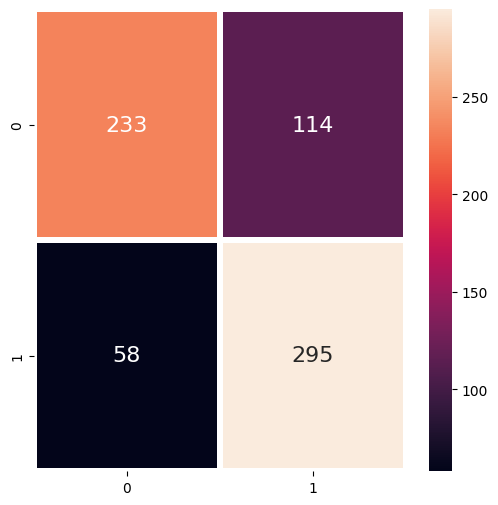

In [269]:
plt.figure(figsize=(6,6))
sns.heatmap(cm_train,annot=True,fmt=',.0f',linewidths=3, annot_kws={"fontsize":16})

In [270]:
accuracy,precision,recall=model_validation_metrics(cm_train)
print('Akurasi :', accuracy)
print('Presisi', precision)
print('Recall', recall)

Akurasi : 0.7542857142857143
Presisi 0.7212713936430318
Recall 0.8356940509915014


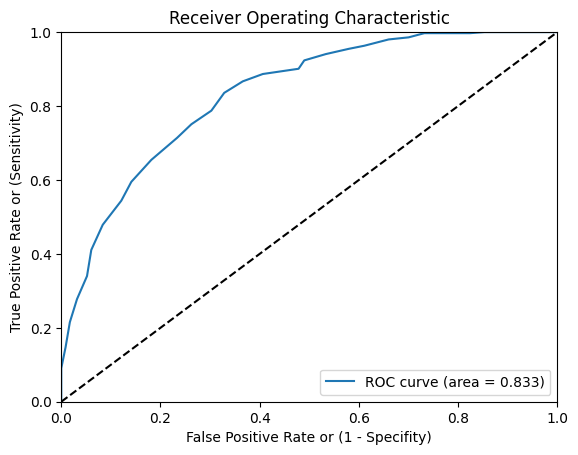

In [271]:
roc_curve_func(y_train,y_train_pred_proba)

#### Cross-Validation

In [272]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)

In [273]:
cm_train=confusion_matrix(y_train, y_train_pred)
cm_test=confusion_matrix(y_test, y_test_pred)

In [274]:
def basic_eval(tm,cm):
  plt.figure(figsize=(6,6))
  plt.title(tm+" Evaluation")
  sns.heatmap(cm,annot=True,fmt=',.0f',linewidths=3, annot_kws={"fontsize":16})
  accuracy,precision,recall=model_validation_metrics(cm)
  print("accuracy :",accuracy)
  print("precision :",precision)
  print("recall :",recall)

accuracy : 0.7542857142857143
precision : 0.7212713936430318
recall : 0.8356940509915014


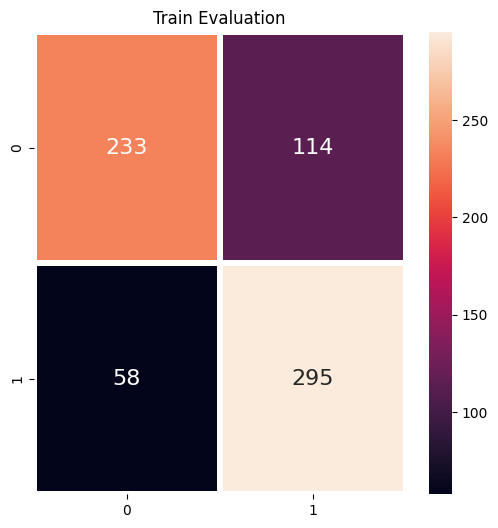

In [275]:
basic_eval('Train',cm_train)

accuracy : 0.7466666666666667
precision : 0.7028571428571428
recall : 0.8367346938775511


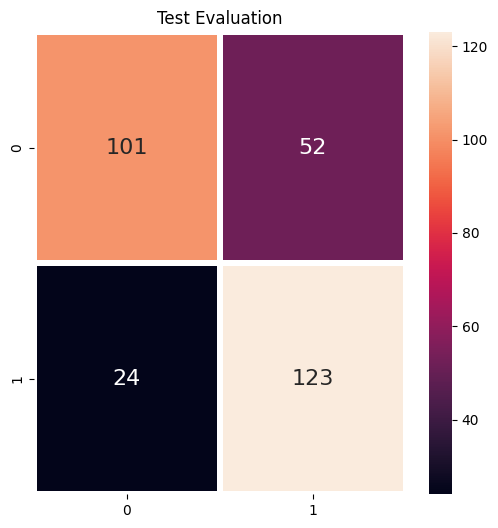

In [276]:
basic_eval('Test',cm_test)

#### Bias-variance trade-off

In [277]:
## Check on hyperparameter changing
hyper_param_list=[x for x in range(30, 41)]

In [278]:
df_trade_off=[]
for md in hyper_param_list:
  model_trade_off=KNeighborsClassifier(n_neighbors=md, weights='uniform', algorithm='auto', p=2)

  # model_base=RandomForestClassifier(n_estimators=40, max_depth=md,min_samples_split=3)
  # model_churn_trade_off=AdaBoostClassifier(base_estimator=model_base, n_estimators=15, learning_rate=0.2, random_state=321)

  model_trade_off.fit(X_train,y_train)
  y_train_pred_temp=model_trade_off.predict(X_train)
  y_test_pred_temp=model_trade_off.predict(X_test)
  cm_train=confusion_matrix(y_train, y_train_pred_temp)
  cm_test=confusion_matrix(y_test, y_test_pred_temp)
  acc_train,p,r=model_validation_metrics(cm_train)
  acc_test,p,r =model_validation_metrics(cm_test)
  df_trade_off.append([acc_train,acc_test])
df_trade_off=pd.DataFrame(df_trade_off,columns=['train_accuracy','test_accuracy'],index=hyper_param_list)

<Axes: >

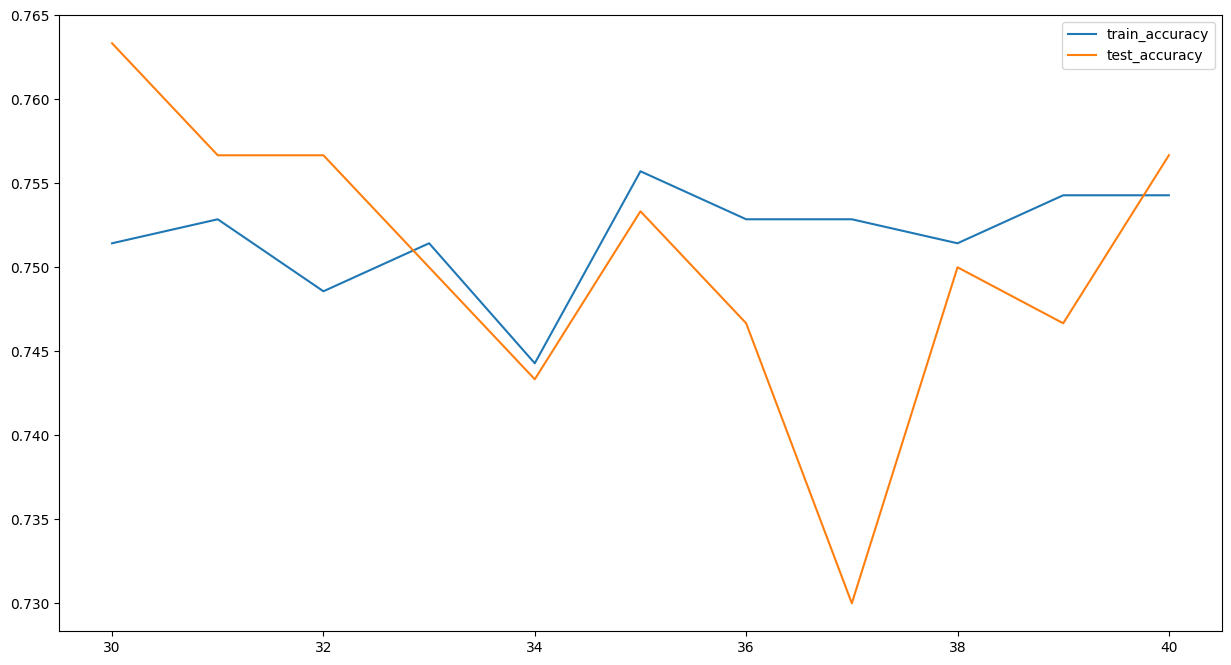

In [279]:
df_trade_off.plot(figsize=(15,8))

### Accuracy Score

In [280]:
#Import modul scikit-learn metrics
from sklearn import metrics
# Model Accuracy
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7466666666666667


In [281]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.66      0.73       153
           1       0.70      0.84      0.76       147

    accuracy                           0.75       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.75      0.74       300



## Random Forest

In [282]:
from sklearn.ensemble import RandomForestClassifier

### Train Model


In [287]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
model2 = RandomForestClassifier(
    bootstrap=True,                # Whether bootstrap samples are used when building trees.
    ccp_alpha=0.0,                 # Complexity parameter used for Minimal Cost-Complexity Pruning.
    class_weight=None,             # Weights associated with classes.
    criterion='gini',              # Function to measure the quality of a split.
    max_depth=9,                   # Maximum depth of the tree.
    max_features='sqrt',           # Number of features to consider when looking for the best split.
    max_leaf_nodes=6,              # Grow trees with `max_leaf_nodes` in best-first fashion.
    max_samples=None,              # Number of samples to draw from X to train each base estimator.
    min_impurity_decrease=0.0,     # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    min_samples_leaf=1,            # Minimum number of samples required to be at a leaf node.
    min_samples_split=4,           # Minimum number of samples required to split an internal node.
    min_weight_fraction_leaf=0.0,  # Minimum weighted fraction of the sum total of weights required to be at a leaf node.
    n_estimators=7,                # Number of trees in the forest.
    n_jobs=None,                   # Number of jobs to run in parallel. None means 1.
    oob_score=False,               # Whether to use out-of-bag samples to estimate the generalization accuracy.
    random_state=42,               # Control the randomness of the estimator.
    verbose=0,                     # Controls the verbosity when fitting and predicting.
    warm_start=False               # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble.
)


In [288]:
model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_leaf_nodes=6, min_samples_split=4,
                       n_estimators=7, random_state=42)

### Cross-Validation

In [291]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)

In [292]:
cm_train=confusion_matrix(y_train, y_train_pred)
cm_test=confusion_matrix(y_test, y_test_pred)

accuracy : 0.7542857142857143
precision : 0.7302798982188295
recall : 0.8130311614730878


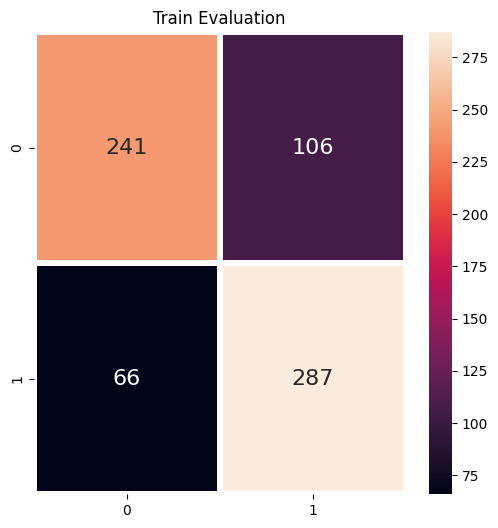

In [289]:
basic_eval('Train',cm_train)

accuracy : 0.7566666666666667
precision : 0.7176470588235294
recall : 0.8299319727891157


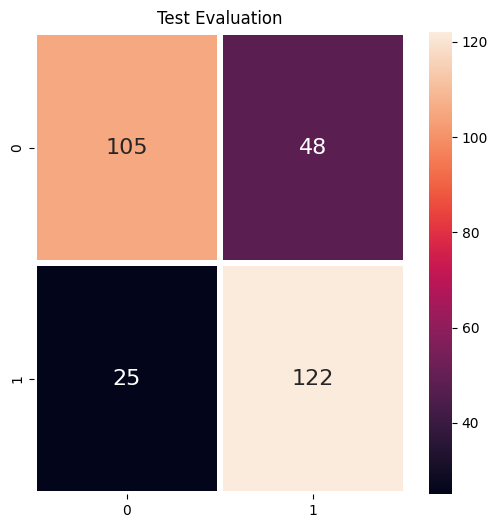

In [290]:
basic_eval('Test',cm_test)

### Bias-variance trade-off

In [293]:
hyper_param_list=[x for x in range(2, 10)]

In [294]:
df_trade_off=[]
for md in hyper_param_list:
  model_trade_off=RandomForestClassifier(min_samples_split=md, random_state=101)

  # model_base=RandomForestClassifier(n_estimators=40, max_depth=md,min_samples_split=3)
  # model_churn_trade_off=AdaBoostClassifier(base_estimator=model_base, n_estimators=15, learning_rate=0.2, random_state=321)

  model_trade_off.fit(X_train,y_train)
  y_train_pred_temp=model_trade_off.predict(X_train)
  y_test_pred_temp=model_trade_off.predict(X_test)
  cm_train=confusion_matrix(y_train, y_train_pred_temp)
  cm_test=confusion_matrix(y_test, y_test_pred_temp)
  acc_train,p,r=model_validation_metrics(cm_train)
  acc_test,p,r =model_validation_metrics(cm_test)
  df_trade_off.append([acc_train,acc_test])
df_trade_off=pd.DataFrame(df_trade_off,columns=['train_accuracy','test_accuracy'],index=hyper_param_list)

<Axes: >

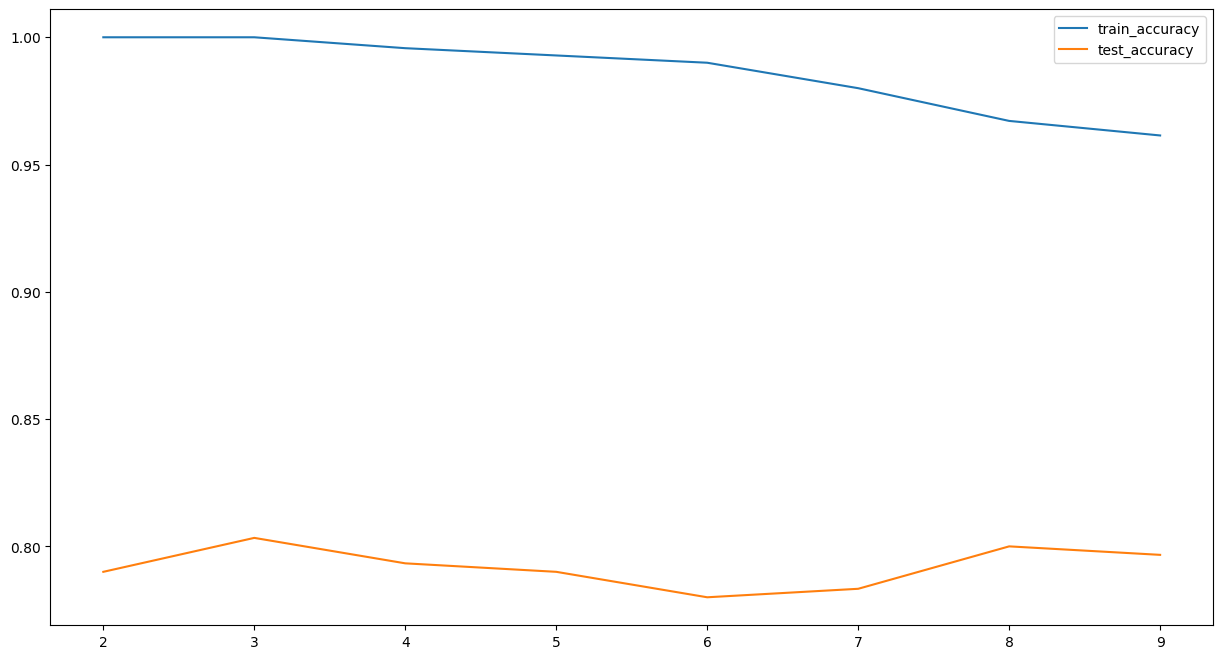

In [295]:
df_trade_off.plot(figsize=(15,8))

### Model Selection

In [296]:
from sklearn.model_selection import GridSearchCV

In [297]:
parameters = {'n_estimators':[1, 3, 5, 7],'max_depth':[3, 5, 8, 9], 'min_samples_split':[4, 6],'max_leaf_nodes':[3, 6, 11]}

clf_search1 = GridSearchCV(model2, parameters, cv=5,verbose=1)

In [298]:
L0=time.time()
clf_search1.fit(X_train,y_train)
print(time.time()-L0)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
5.622016429901123


In [299]:
clf_search1.best_estimator_

RandomForestClassifier(max_depth=8, max_leaf_nodes=11, min_samples_split=4,
                       n_estimators=7, random_state=42)

### Accuracy Score

In [300]:
#Import modul scikit-learn metrics
from sklearn import metrics
# Model Accuracy
y_pred = model2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.75


In [301]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       153
           1       0.72      0.80      0.76       147

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



In [302]:
df_imp = pd.DataFrame({'cols':cols,'importance':model2.feature_importances_})
df_imp = df_imp.set_index('cols')

<Axes: ylabel='cols'>

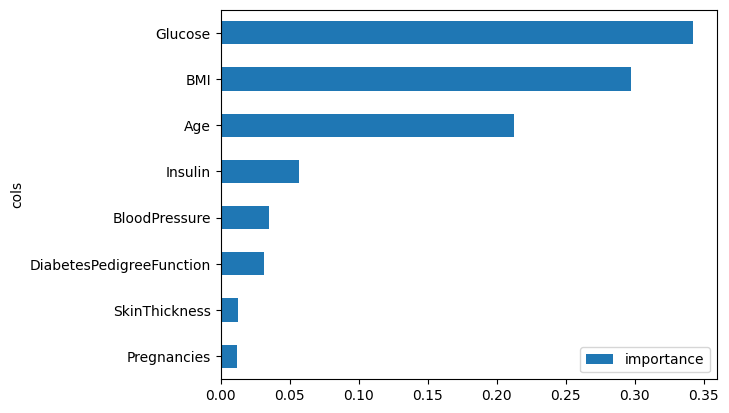

In [303]:
df_imp.sort_values('importance').plot(kind = 'barh')